In [ ]:
!pip install pycountry_convert

In [2]:
import pandas as pd
# import pycountry_convert as pc

import seaborn as sns
import matplotlib.pyplot as plt

# Lecture des données

In [58]:
financement_df = pd.read_csv("financement.csv", sep=",", index_col=0) # Lecture du fichier csv

# Analyse

In [59]:
print("Columns :", financement_df.columns)

Columns : Index(['ID', 'nom', 'categorie', 'categorie_principale', 'monaie',
       'date_butoire', 'objectif', 'lancement', 'promesse', 'etat',
       'supporters', 'pays', 'promesse_usd1', 'promesse_usd2', 'objectif_usd'],
      dtype='object')


In [60]:
financement_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    378661 non-null  int64  
 1   nom                   378657 non-null  object 
 2   categorie             378661 non-null  object 
 3   categorie_principale  378661 non-null  object 
 4   monaie                378661 non-null  object 
 5   date_butoire          378661 non-null  object 
 6   objectif              378661 non-null  float64
 7   lancement             378661 non-null  object 
 8   promesse              378661 non-null  float64
 9   etat                  378661 non-null  object 
 10  supporters            378661 non-null  int64  
 11  pays                  378661 non-null  object 
 12  promesse_usd1         374864 non-null  float64
 13  promesse_usd2         378661 non-null  float64
 14  objectif_usd          378661 non-null  float64
dtype

In [61]:
pd.DataFrame({'total_missing': financement_df.isnull().sum(), 'perc_missing': (financement_df.isnull().sum()/len(financement_df))*100})

,total_missing,perc_missing
ID,0,0.000000
nom,4,0.001056
categorie,0,0.000000
categorie_principale,0,0.000000
monaie,0,0.000000
date_butoire,0,0.000000
objectif,0,0.000000
lancement,0,0.000000
promesse,0,0.000000
etat,0,0.000000


On remarque que nous avons quelques valeurs manquantes dans notre dataframe. 4 pour le champs "nom" et 3797 pour le champs "promesse_usd1". Le taux de données manquantes étant faible, nous décidons de supprimer les lignes.

In [62]:
financement_df.dropna(inplace=True)

### Analyse de la variable à prédire

Analysons la variable que nous souhaitons prédire (etat)

In [63]:
financement_df["etat"].unique()

array(['failed', 'canceled', 'successful', 'live', 'suspended'],
      dtype=object)

In [64]:
financement_df["etat"].value_counts()

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: etat, dtype: int64

On ne rend pas vraiment compte de la proportion dans le dataset final. Regardons plûtot la proportion.

In [65]:
financement_df["etat"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

failed        52.7%
successful    35.7%
canceled      10.3%
live           0.7%
suspended      0.5%
Name: etat, dtype: object

On remarque que les deux modalités : live, suspended ne représentent que 1.3% de l'ensemble de nos enregistrements (respectivement 0.7% et 0.5%). On décide donc de suppimer les lignes avec ces deux modalités vu qu'elles ne représentent qu'une partie de notre échantillon. 

In [66]:
financement_df = financement_df[~financement_df["etat"].isin(["undefined", "live", "suspended"])]

On remarque aussi que la colonne que nous souhaitons prédire est du String. Mappons là en integer. On décide de regrouper failed et canceled pour faire de la classification binaire

In [67]:
financement_df["etat_int"] = financement_df["etat"].map({'failed': 0, 'canceled': 0, 'successful': 1})

<ipython-input-67-993081813a57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financement_df["etat_int"] = financement_df["etat"].map({'failed': 0, 'canceled': 0, 'successful': 1})


## Analyse des variables numériques

In [68]:
describe_df = financement_df.describe().apply(lambda x: x.apply('{0:.2f}'.format))
describe_df

,ID,objectif,promesse,supporters,promesse_usd1,promesse_usd2,objectif_usd,etat_int
count,370219.00,370219.00,370219.00,370219.00,370219.00,370219.00,370219.00,370219.00
mean,1074476926.20,48659.24,9750.20,106.99,7076.49,9144.48,45091.69,0.36
std,619206866.95,1160229.43,96239.49,915.27,78822.90,91581.26,1128616.59,0.48
min,5971.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00
25%,537570578.50,2000.00,32.00,2.00,19.00,32.44,2000.00,0.00
50%,1075162847.00,5500.00,630.00,12.00,402.64,632.47,5500.00,0.00
75%,1610098310.50,16500.00,4100.58,57.00,3065.00,4076.00,15984.95,1.00
max,2147476221.00,100000000.00,20338986.27,219382.00,20338986.27,20338986.27,166361390.71,1.00


On remarque que pour chaque variable, la moyenne est supérieur au 3 quartile, ce qui signifie qu'il y a des valeurs (élevées) extrèmes.
Essayons, de représenter ça avec des boites à moustache

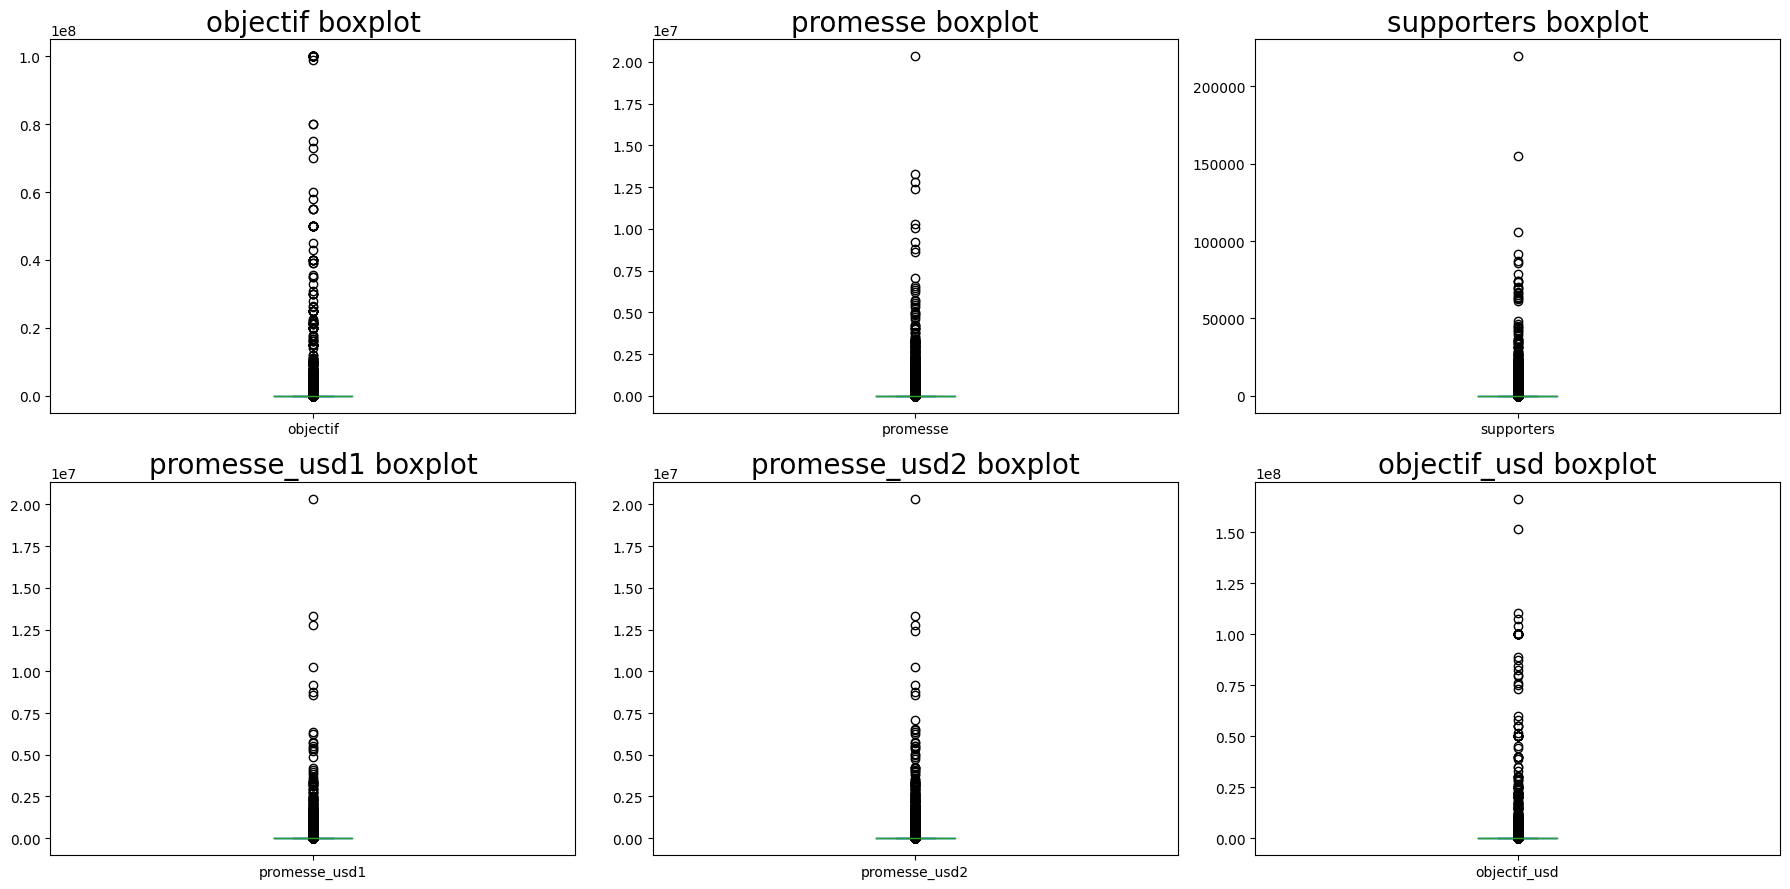

In [69]:
num_col = ['objectif', 'promesse', 'supporters', 'promesse_usd1', 'promesse_usd2', 'objectif_usd']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,9))

for i, ax in enumerate(axes.flat):
    financement_df[num_col[i]].plot.box(ax=ax)
    ax.set_title(f"{num_col[i]} boxplot", fontsize=20)

plt.tight_layout()
plt.show()

On remarque clairement qu'il y a de nombreuses valeurs extrèmes. Elles semblent être des données légitimes. Pour que notre modèle soit le plus performant possible, il semble intéressant de créer des categories.

In [71]:
for col in num_col:
  col_stats = financement_df[col].describe()
  bins = [
      col_stats.get("min"), 
      col_stats.get("25%"), 
      col_stats.get("50%"), 
      col_stats.get("75%"), 
      col_stats.get("max"), 
  ]

  labels = ['Très faible', 'Faible', 'Moyen', 'Elevé']
  financement_df[f'{col}_cat'] = pd.cut(financement_df[col], bins=bins, labels=labels)

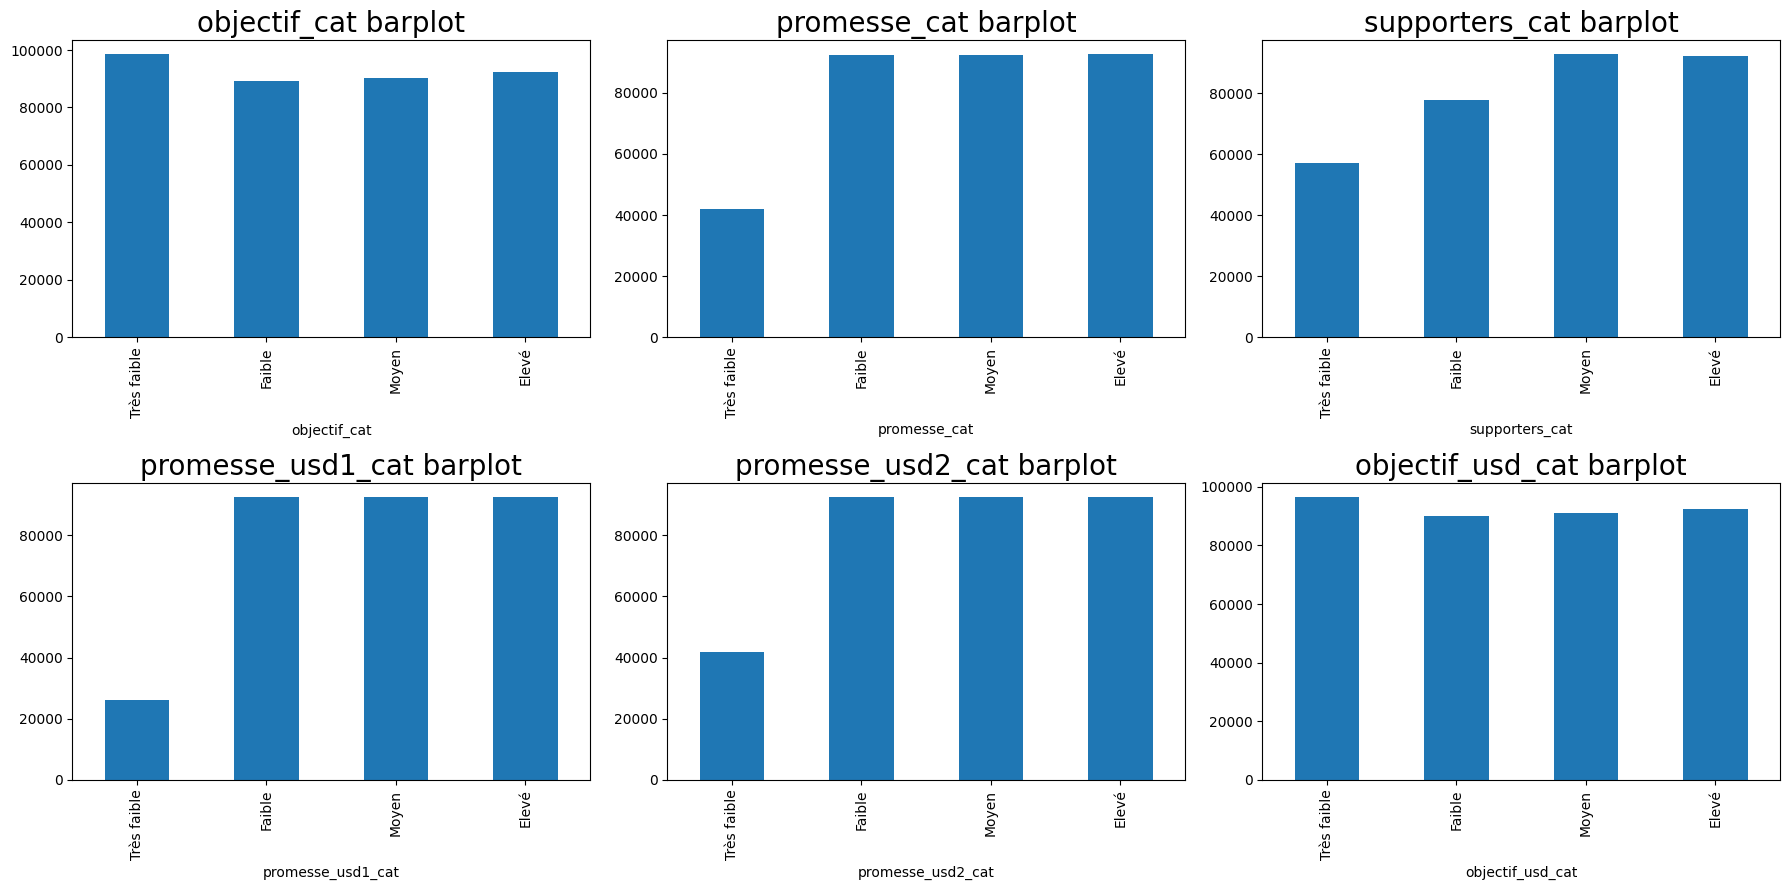

In [73]:
cat_col = [col for col in financement_df.columns if col.endswith("_cat")]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,9))

for i, ax in enumerate(axes.flat):
    financement_df.groupby(f'{cat_col[i]}')[cat_col[i].split("_cat")[0]].count().plot.bar(ax=ax)
    ax.set_title(f"{cat_col[i]} barplot", fontsize=20)

plt.tight_layout()
plt.show()

In [76]:
financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[cat_col])], axis=1)

In [85]:
corr_matrix = financement_df.corr()
corr_matrix["etat_int"].abs().sort_values(ascending=False)

<ipython-input-85-7b2db29e1402>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = financement_df.corr()


etat_int                         1.000000
supporters_cat_Elevé             0.562955
promesse_usd2_cat_Elevé          0.538918
promesse_cat_Elevé               0.533315
promesse_usd1_cat_Elevé          0.519521
supporters_cat_Très faible       0.310826
promesse_usd2_cat_Faible         0.304598
promesse_cat_Faible              0.296731
supporters_cat_Faible            0.280767
promesse_usd1_cat_Faible         0.275172
promesse_cat_Très faible         0.261572
promesse_usd2_cat_Très faible    0.260862
supporters_cat_Moyen             0.199080
objectif_usd_cat_Elevé           0.194557
promesse_usd2_cat_Moyen          0.194305
objectif_cat_Elevé               0.193307
promesse_cat_Moyen               0.193009
promesse_usd1_cat_Très faible    0.190002
objectif_cat_Très faible         0.155369
objectif_usd_cat_Très faible     0.153928
promesse_usd1_cat_Moyen          0.147604
supporters                       0.129199
promesse                         0.112160
promesse_usd2                    0

Nous pouvons remarquer que les catégories que nous avons créées sont beaucoup plus corrélées à la variable 'etat_int' que les variables d'origine. Nous constatons également que ce sont les catégories extrêmes ('Elevé' et 'Faible') qui ont les taux de corrélation les plus élevés.

# Analyse des variables non numériques

Commençons par lister les variables non numériques

In [93]:
list(financement_df.select_dtypes(exclude=['uint8', 'int', 'float', 'category']).columns)

['nom',
 'categorie',
 'categorie_principale',
 'monaie',
 'date_butoire',
 'lancement',
 'etat',
 'pays']

Tout d'abord, analysons si certains mots reviennent plus fréquemment dans les noms des projets financés ou non financés.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


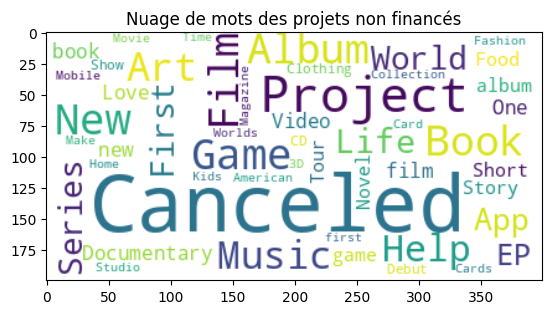

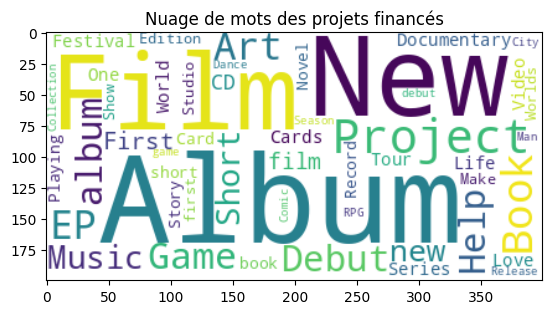

In [96]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

nltk.download('stopwords')
stop_words = stopwords.words('english')

translator = str.maketrans('', '', string.punctuation)

def remove_stopwords(text):

    text = str(text).translate(translator)

    filtered_text = [word for word in text.split() if word.lower() not in stop_words]
    filtered_text = [word for word in filtered_text if not word.isdigit()]

    return " ".join(filtered_text)

financement_df['nom'] = financement_df['nom'].apply(remove_stopwords)

cloud_generator = WordCloud(background_color='white', random_state=1)

wordcloud_image = cloud_generator.fit_words(financement_df[financement_df["etat_int"] == 0]["nom"].str.split(expand=True).stack().value_counts().head(50))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title("Nuage de mots des projets non financés")
plt.show()

wordcloud_image = cloud_generator.fit_words(financement_df[financement_df["etat_int"] == 1]["nom"].str.split(expand=True).stack().value_counts().head(50))
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title("Nuage de mots des projets financés")
plt.show()

In [98]:
print("Mots les plus fréquent dans les projets non financés :")
display(financement_df[financement_df["etat_int"] == 0]["nom"].str.split(expand=True).stack().value_counts().head(10))

print("\nMots les plus fréquent dans les projets non financés :")
display(financement_df[financement_df["etat_int"] == 1]["nom"].str.split(expand=True).stack().value_counts().head(10))

Mots les plus fréquent dans les projets non financés


Canceled    23125
Project      5983
New          4270
Game         4246
Book         3904
Film         3808
Album        3796
Art          3676
Music        3358
Help         3090
dtype: int64


Mots les plus fréquent dans les projets non financés


Album      5234
New        4353
Film       3862
Project    3627
Book       2855
EP         2589
Art        2435
Game       2344
Help       2178
album      2121
dtype: int64

Nous pouvons remarquer que les mots qui reviennent le plus fréquemment sont souvent les mêmes, que le projet soit financé ou non financé...

Penchons nous maintenant sur les categories du projet

In [171]:
# Calcule le nombre de projets financés et non financés pour chaque catégorie
count_by_category_state = financement_df.groupby(["categorie", "etat_int"])["ID"].count().reset_index()
count_by_category_state.columns = ["categorie", "etat_int", "nb"]

# Calcule la proportion de projets financés pour chaque catégorie
total_by_category = count_by_category_state.groupby("categorie")["nb"].transform("sum")
count_by_category_state["proportion"] = count_by_category_state["nb"] / total_by_category

# Transpose la table pivotée
proportions_by_category = count_by_category_state.pivot(index="categorie", columns="etat_int", values="proportion").reset_index()
proportions_by_category.columns = ["categorie", "non_finance", "finance"]

<Axes: title={'center': 'Stacked Bar Graph'}, xlabel='categorie'>

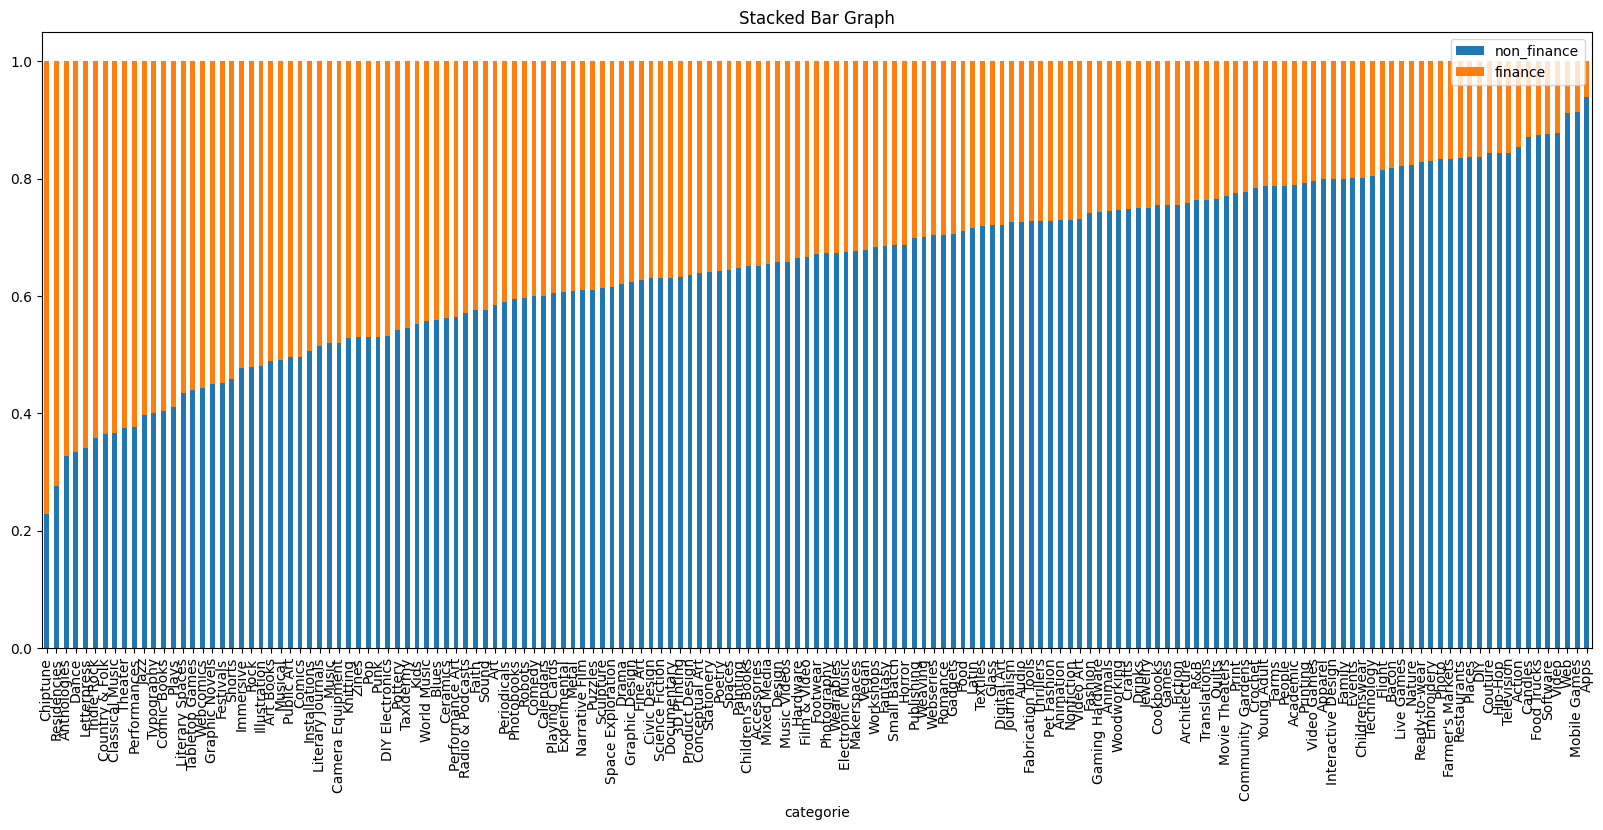

In [176]:
fig, ax = plt.subplots(figsize=(20, 8))
proportions_by_category.sort_values(by='finance', ascending=False).plot(
  x = 'categorie',
  kind = 'bar',
  stacked = True,
  title = "Proportion de l'etat du projet (financé ou non) par categorie",
  mark_right = True, 
  ax=ax
)

Il est évident que certaines catégories ont une plus grande probabilité d'être financées que d'autres. Par exemple, près de 80% des projets Chiptune ont été financés, tandis que seulement 10% des projets Apps ont été financés.

Vérifions notre observations avec la vartiable categorie_principale

In [180]:
# Calcule le nombre de projets financés et non financés pour chaque catégorie
count_by_main_category_state = financement_df.groupby(["categorie_principale", "etat_int"])["ID"].count().reset_index()
count_by_main_category_state.columns = ["categorie_principale", "etat_int", "nb"]

# Calcule la proportion de projets financés pour chaque catégorie
total_by_main_category = count_by_main_category_state.groupby("categorie_principale")["nb"].transform("sum")
count_by_main_category_state["proportion"] = count_by_main_category_state["nb"] / total_by_main_category

# Transpose la table pivotée
proportions_by_main_category = count_by_main_category_state.pivot(index="categorie_principale", columns="etat_int", values="proportion").reset_index()
proportions_by_main_category.columns = ["categorie_principale", "non_finance", "finance"]

<Axes: title={'center': "Proportion de l'etat du projet (financé ou non) par categorie_principale"}, xlabel='categorie_principale'>

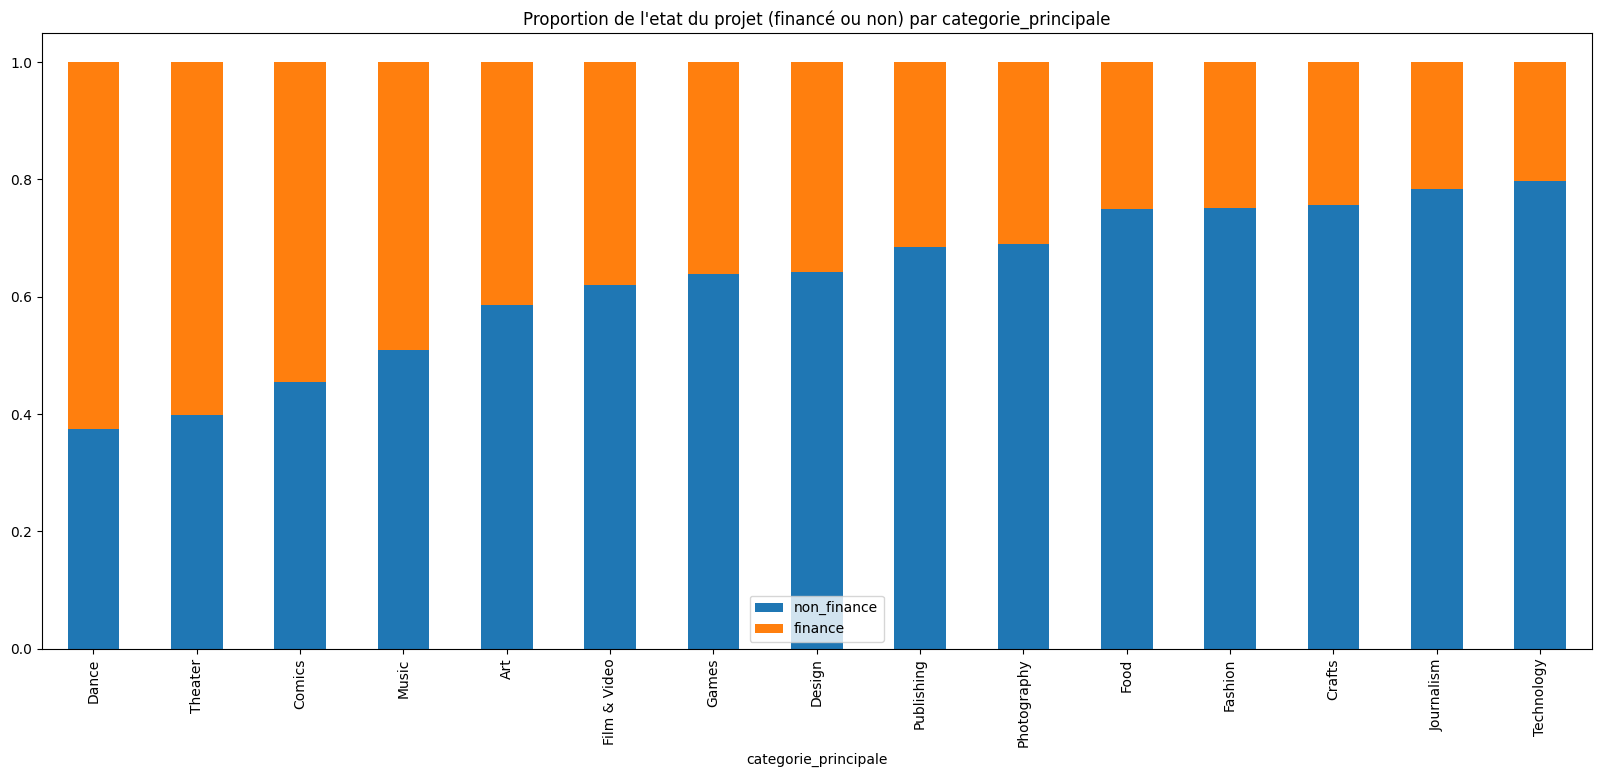

In [179]:
fig, ax = plt.subplots(figsize=(20, 8))
proportions_by_main_category.sort_values(by='finance', ascending=False).plot(
  x = 'categorie_principale',
  kind = 'bar',
  stacked = True,
  title = "Proportion de l'etat du projet (financé ou non) par categorie_principale",
  mark_right = True, 
  ax=ax
)

In [181]:
financement_df["categorie_principale"].value_counts()

Film & Video    62247
Music           49101
Publishing      39014
Games           34719
Technology      31761
Design          29515
Art             27862
Food            24263
Fashion         22424
Theater         10850
Comics          10720
Photography     10675
Crafts           8661
Journalism       4671
Dance            3736
Name: categorie_principale, dtype: int64

Même observation avec categorie_principale. De plus nous pouvons confirmer notre observation du fait du nombre important de projet pour chaque catégorie_principale.
Nous pouvons en conclure que categorie et categorie_principale peuvent nous aider à savoir si un projet va être financé ou non.

Pour pouvoir utiliser ces variables, nous allons les dummifier

In [182]:
financement_df = pd.concat([financement_df.copy(), pd.get_dummies(financement_df[["categorie", "categorie_principale"]])], axis=1)